# Week 5: RNN, LSTM, & Transformer

## Libraries

In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.utils import timeseries_dataset_from_array
from keras import layers, models, Input
from sklearn.preprocessing import MinMaxScaler
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import math
from sklearn.metrics import mean_squared_error

## Loading Dataset and Preprocessing

In [50]:
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [51]:
# Convert date
df["Date"] = pd.to_datetime(df["Date"]).map(pd.Timestamp.toordinal)
dates = df["Date"].copy()

# Drop non-numeric column
# df = df.drop(columns=["Name"])
df = df.drop(columns=["Name", "Date"])

# Select input features and target
# feature_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
feature_cols = ["Open", "High", "Low", "Close", "Volume"]
X_raw = df[feature_cols].values
y_raw = df["Close"].values.reshape(-1, 1)

In [52]:
# Scale inputs
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X_raw)

# Scale target
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y_raw)


## Train-test split

In [53]:
seq_len = 50
forecast_horizon = 7  # Predict 7 days into the future

X_data = X_scaled       # (N, 5)
y_data = y_scaled       # (N, 1)

total_shift = seq_len + forecast_horizon - 1


# Trim X_data from the end
X_trimmed = X_data[:-total_shift]
y_shifted = y_data[total_shift:]

split = int(len(X_trimmed) * 0.8)

X_train = X_trimmed[:split]
y_train = y_shifted[:split]

X_test = X_trimmed[split:]
y_test = y_shifted[split:]


train_data = tf.keras.utils.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=seq_len,
    sequence_stride=1,
    shuffle=True,
    batch_size=32,
)

test_data = tf.keras.utils.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=seq_len,
    sequence_stride=1,
    shuffle=False,
    batch_size=32,
)


## RNN

In [54]:
model_rnn = models.Sequential([
    Input(shape=(seq_len, 5)),
    layers.SimpleRNN(64, return_sequences=True),  # , input_shape=(seq_len, 5)),
    layers.Dropout(0.2),

    layers.SimpleRNN(64),
    layers.Dropout(0.2),

    layers.Dense(32, activation="relu"),
    layers.Dense(1),
])

model_rnn.compile(optimizer="adam", loss="mse")

history = model_rnn.fit(train_data, epochs=10)

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0383
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0044
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.0259e-04
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1939e-04
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.9476e-04
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7906e-04


In [55]:
def plot_train_test_predictions(train, test_true, test_pred, dates, title):
    plt.figure(figsize=(14, 5))

    # X-axis indices
    train_x = np.arange(len(train))
    test_x = np.arange(len(train), len(train) + len(test_true))

    # Plot lines
    plt.plot(train_x, train, label="Training Price")
    plt.plot(test_x, test_true, label="True Test Price")
    plt.plot(test_x, test_pred, label="Predicted Test Price")

    # Convert ordinal dates to actual datetime
    dates = dates.apply(pd.Timestamp.fromordinal)

    # Build date array for the entire plotted range
    all_dates = dates[:len(train) + len(test_true)]

    # Find the FIRST available date of each year
    tick_idx = []
    tick_labels = []
    seen_years = set()

    for i, d in enumerate(all_dates):
        if d.year not in seen_years:
            seen_years.add(d.year)
            tick_idx.append(i)
            tick_labels.append(str(d.year))

    # Apply ticks
    plt.xticks(tick_idx, tick_labels, rotation=45)

    plt.xlabel("Date")
    plt.ylabel("AMZN Close Price ($)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


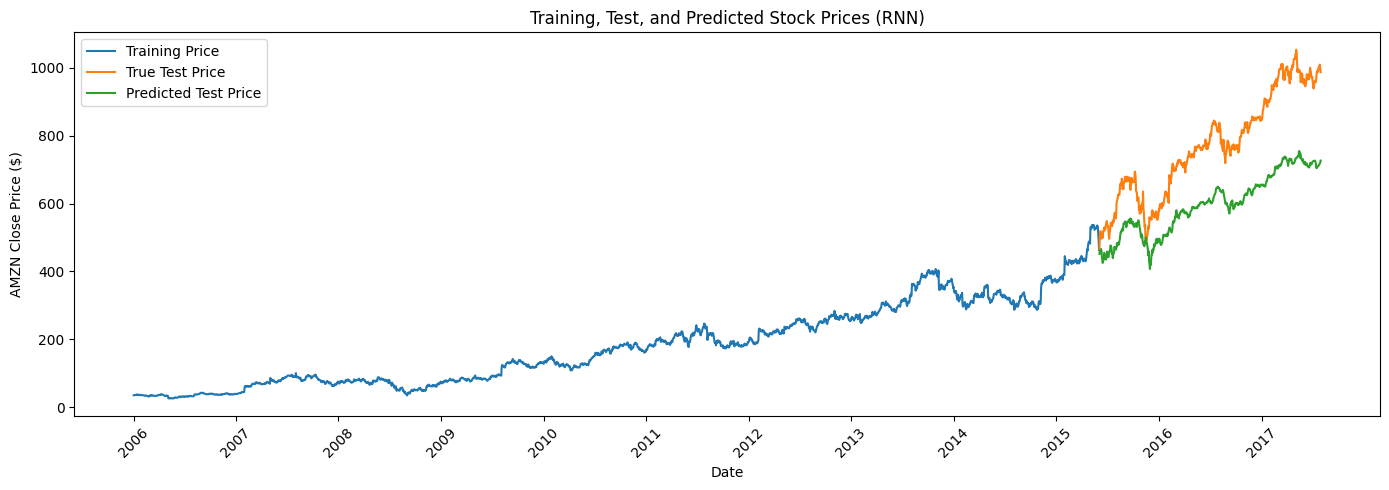

In [56]:
pred_scaled = model_rnn.predict(test_data)
true_scaled = np.concatenate([y for X, y in test_data], axis=0)

pred = target_scaler.inverse_transform(pred_scaled).flatten()
true = target_scaler.inverse_transform(true_scaled).flatten()

data = target_scaler.inverse_transform(y_train).flatten()

plot_train_test_predictions(
    train=data,
    test_true=true,
    test_pred=pred,
    # dates=df["Date"],
    dates=dates,
    title="Training, Test, and Predicted Stock Prices (RNN)"
)


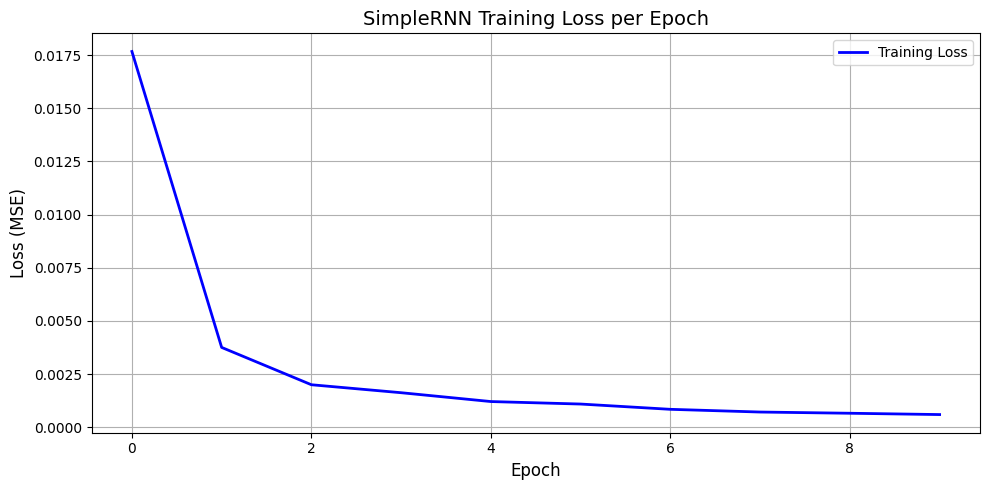

In [57]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)

plt.title("SimpleRNN Training Loss per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LSTM

In [58]:
model = models.Sequential([
    Input(shape=(seq_len, 5)),
    layers.LSTM(128, return_sequences=True),  # , input_shape=(seq_len, 5)),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

history = model.fit(train_data, epochs=10)

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0043
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8504e-04
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3148e-04
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0488e-04
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1819e-04
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1790e-04
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0189e-04
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8758e-04
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9276e-04
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6969e-04


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


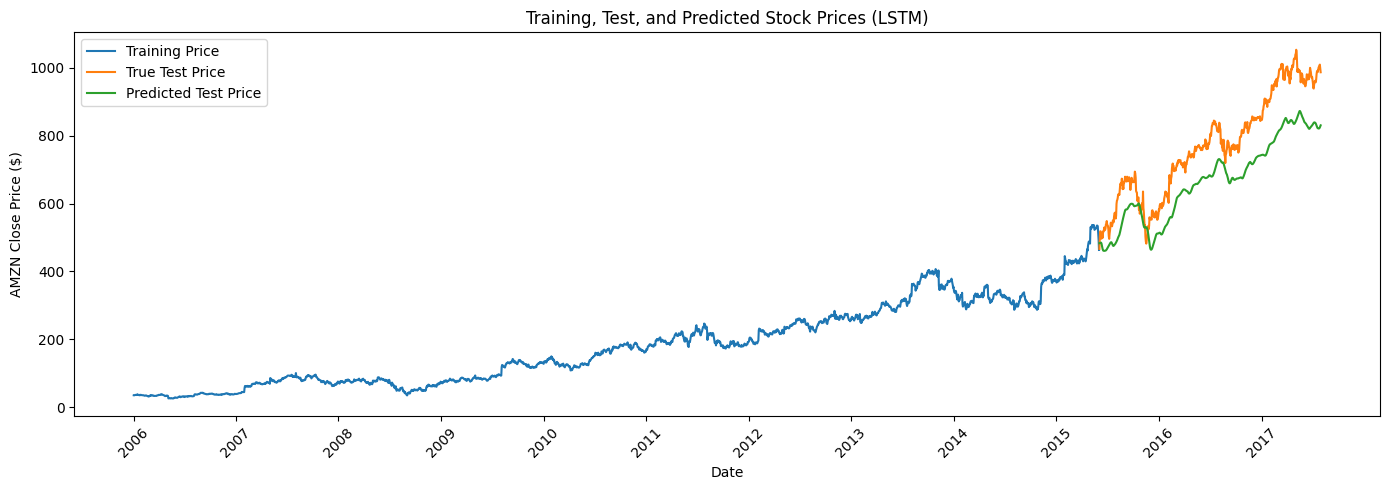

In [59]:
pred_scaled = model.predict(test_data)
true_scaled = np.concatenate([y for X, y in test_data], axis=0)

pred = target_scaler.inverse_transform(pred_scaled).flatten()
true = target_scaler.inverse_transform(true_scaled).flatten()

data = target_scaler.inverse_transform(y_train).flatten()

plot_train_test_predictions(
    train=data,
    test_true=true,
    test_pred=pred,
    # dates=df["Date"],
    dates=dates,
    title="Training, Test, and Predicted Stock Prices (LSTM)"
)


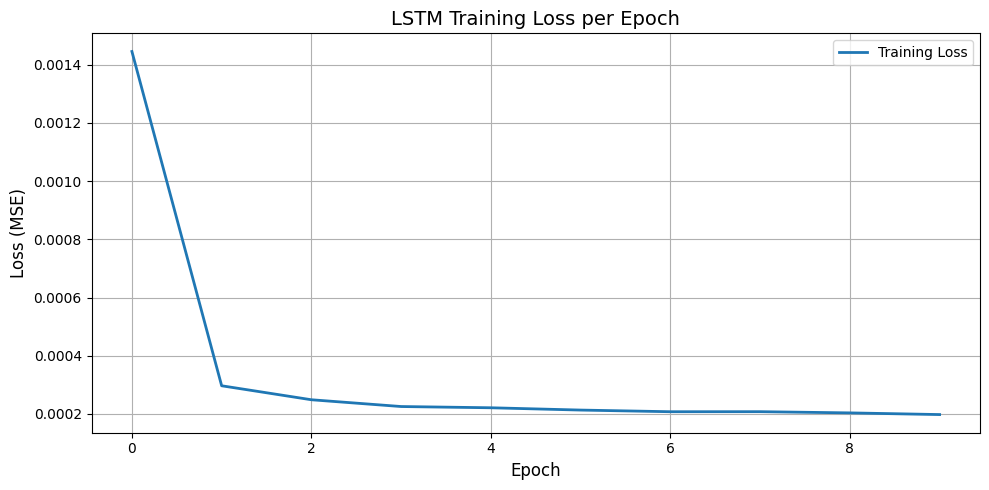

In [60]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)

plt.title("LSTM Training Loss per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Transformer

In [ ]:
# Read Data, convert to sequences, split into train and test sets and load into DataLoaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)
features = ["Open","Close","Volume","High","Low"]
TARGET = "Close"
TARGET_IDX = features.index(TARGET)
data = df[features].values.astype(np.float32)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
SEQ_LEN = 90
TRAIN_RATIO = 0.8
FORECAST_HORIZON = 7

def create_sequences(arr, target_idx, seq_len, horizon):
    X, y = [], []
    for i in range(len(arr) - seq_len - horizon + 1):
        X.append(arr[i : i + seq_len])
        y.append(arr[i + seq_len : i + seq_len + horizon, target_idx])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data_scaled, TARGET_IDX, SEQ_LEN, FORECAST_HORIZON)

N = len(X_all)
train_size = int(N * TRAIN_RATIO)

X_train = torch.tensor(X_all[:train_size], dtype=torch.float32).to(device)
y_train = torch.tensor(y_all[:train_size], dtype=torch.float32).to(device)

X_test = torch.tensor(X_all[train_size:], dtype=torch.float32).to(device)
y_test = torch.tensor(y_all[train_size:], dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=1, shuffle=False)
NUM_FEATURES = X_all.shape[-1]

In [ ]:
# Add positional encoding for Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5_000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10_000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

# Create causal mask for decoder self-attention
def causal_mask(seq_len, device):
    return torch.triu(
        torch.ones(seq_len, seq_len, device=device, dtype=torch.bool),
        diagonal=1
    )

# Transformer Encoder and Decoder Blocks
class EncoderBlock(nn.Module):
    # Encoder block with multi-head self-attention, feed-forward network, layer norm, and dropout
    def __init__(self, d_model, heads, d_ff, dropout):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            d_model, heads, dropout=dropout, batch_first=True
        )
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, S, d_model)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.drop(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.drop(ff_out))
        return x


class DecoderBlock(nn.Module):
    # Decoder block with self-attention, cross-attention, feed-forward network, layer norm, and dropout
    def __init__(self, d_model, heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            d_model, heads, dropout=dropout, batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            d_model, heads, dropout=dropout, batch_first=True
        )

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, enc_output, tgt_mask):
        self_attn_out, _ = self.self_attn(
            x, x, x, attn_mask=tgt_mask
        )
        x = self.norm1(x + self.drop(self_attn_out))

        cross_attn_out, _ = self.cross_attn(
            x, enc_output, enc_output
        )
        x = self.norm2(x + self.drop(cross_attn_out))

        ff_out = self.ff(x)
        x = self.norm3(x + self.drop(ff_out))
        return x


class Seq2SeqTransformer(nn.Module):
    # Seq2Seq Transformer for time series forecasting with 6 stacked encoder and decoder blocks
    def __init__(self, input_dim, d_model=128, heads=4, layers=6,
                 d_ff=512, dropout=0.1, output_len=7):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.output_len = output_len

        # Encoder
        self.enc_proj = nn.Linear(input_dim, d_model)
        self.encoder = nn.ModuleList([
            EncoderBlock(d_model, heads, d_ff, dropout)
            for _ in range(layers)
        ])
        # Decoder
        self.dec_value_proj = nn.Linear(1, d_model)
        self.decoder = nn.ModuleList([
            DecoderBlock(d_model, heads, d_ff, dropout)
            for _ in range(layers)
        ])
        # positional encoding
        self.pos = PositionalEncoding(d_model)
        self.fc = nn.Linear(d_model, 1)
        self.drop = nn.Dropout(dropout)

    def encode(self, x):
        x = self.enc_proj(x) * math.sqrt(self.d_model)  
        x = self.pos(x)
        for block in self.encoder:
            x = block(x)
        return x

    def decode_teacher_forcing(self, enc_output, x, y):
        # Decoder during training: uses real target values (teacher forcing) to prevent error accumulation
        B = x.size(0)
        device = x.device
        last_target = x[:, -1, -1].unsqueeze(1)  # (B, 1)
        y_prev = torch.cat([last_target, y[:, :-1]], dim=1) 

        dec_vals = y_prev.unsqueeze(-1)  
        dec_input = self.dec_value_proj(dec_vals) * math.sqrt(self.d_model)
        dec_input = self.pos(dec_input)
        dec_input = self.drop(dec_input)

        S_dec = dec_input.size(1)
        tgt_mask = causal_mask(S_dec, device) 

        dec_output = dec_input
        for block in self.decoder:
            dec_output = block(dec_output, enc_output, tgt_mask)

        preds = self.fc(dec_output).squeeze(-1)  
        return preds

    def decode_autoregressive(self, enc_output, x):
        # Decode block used during inference, which uses its own previous predictions
        B = x.size(0)
        device = x.device
        last_target = x[:, -1, -1].unsqueeze(1) 
        prev_y = last_target  

        preds = []
        dec_vals = None 

        for t in range(self.output_len):
            if dec_vals is None:
                dec_vals = prev_y.unsqueeze(-1) 
            else:
                dec_vals = torch.cat([dec_vals, prev_y.unsqueeze(-1)], dim=1)  

            dec_input = self.dec_value_proj(dec_vals) * math.sqrt(self.d_model)
            dec_input = self.pos(dec_input)
            dec_input = self.drop(dec_input)

            S_dec = dec_input.size(1)
            tgt_mask = causal_mask(S_dec, device)

            dec_output = dec_input
            for block in self.decoder:
                dec_output = block(dec_output, enc_output, tgt_mask)

            step_pred = self.fc(dec_output[:, -1, :]).squeeze(-1)  
            preds.append(step_pred.unsqueeze(1))  

            prev_y = step_pred.unsqueeze(1)  

        preds = torch.cat(preds, dim=1)
        return preds

    def forward(self, x, y=None):
        enc_output = self.encode(x)

        if self.training and (y is not None):
            return self.decode_teacher_forcing(enc_output, x, y)
        else:
            return self.decode_autoregressive(enc_output, x)

In [ ]:
model = Seq2SeqTransformer(
    input_dim=NUM_FEATURES,
    d_model=128,
    heads=4,
    layers=3,
    d_ff=512,
    dropout=0.1,
    output_len=FORECAST_HORIZON
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 40
print("Training Seq2Seq Transformer...")

loss_history = []
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)           
        yb = yb.to(device)           

        optimizer.zero_grad()
        preds = model(xb, yb)       
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {avg_loss:.6f}")

Training Seq2Seq Transformer...
Epoch 1/40  Loss: 0.041236
Epoch 2/40  Loss: 0.007685
Epoch 3/40  Loss: 0.004036
Epoch 4/40  Loss: 0.002337
Epoch 5/40  Loss: 0.001582
Epoch 6/40  Loss: 0.001142
Epoch 7/40  Loss: 0.000965
Epoch 8/40  Loss: 0.000836
Epoch 9/40  Loss: 0.000641
Epoch 10/40  Loss: 0.000565
Epoch 11/40  Loss: 0.000483
Epoch 12/40  Loss: 0.000435
Epoch 13/40  Loss: 0.000384
Epoch 14/40  Loss: 0.000380
Epoch 15/40  Loss: 0.000386
Epoch 16/40  Loss: 0.000331
Epoch 17/40  Loss: 0.000346
Epoch 18/40  Loss: 0.000320
Epoch 19/40  Loss: 0.000256
Epoch 20/40  Loss: 0.000254
Epoch 21/40  Loss: 0.000255
Epoch 22/40  Loss: 0.000243
Epoch 23/40  Loss: 0.000227
Epoch 24/40  Loss: 0.000247
Epoch 25/40  Loss: 0.000212
Epoch 26/40  Loss: 0.000199
Epoch 27/40  Loss: 0.000195
Epoch 28/40  Loss: 0.000203
Epoch 29/40  Loss: 0.000191
Epoch 30/40  Loss: 0.000203
Epoch 31/40  Loss: 0.000190
Epoch 32/40  Loss: 0.000210
Epoch 33/40  Loss: 0.000197
Epoch 34/40  Loss: 0.000175
Epoch 35/40  Loss: 0.0001

--------------------
H=7 Day Ahead Forecast
 MSE:  15245.9877
 RMSE: 123.4746
--------------------


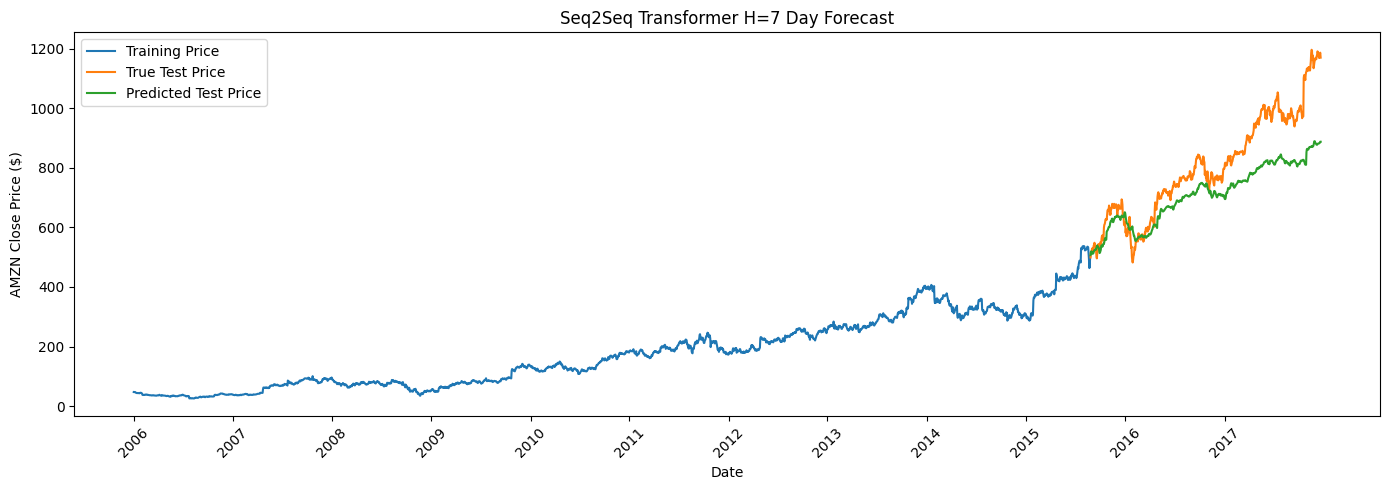

In [ ]:
model.eval()
preds_scaled = []

with torch.no_grad():
    for xb, _ in test_loader:
        pred = model(xb.to(device))        
        pred = pred.cpu().numpy()
        preds_scaled.append(pred)

preds_scaled = np.vstack(preds_scaled)       
y_test_scaled = y_test.cpu().numpy()         


preds_h7 = preds_scaled[:, 6:7]  
true_h7  = y_test_scaled[:, 6:7]  

# inverse transform to get back true values
dummy_pred = np.zeros((len(preds_h7), data.shape[1]))
dummy_true = np.zeros((len(true_h7), data.shape[1]))

dummy_pred[:, TARGET_IDX] = preds_h7[:, 0]
dummy_true[:, TARGET_IDX] = true_h7[:, 0]

pred_close_h7 = scaler.inverse_transform(dummy_pred)[:, TARGET_IDX]
true_close_h7 = scaler.inverse_transform(dummy_true)[:, TARGET_IDX]

# metrics
mse_h7 = mean_squared_error(true_close_h7, pred_close_h7)
rmse_h7 = np.sqrt(mse_h7)

print("-" * 20)
print("H=7 Day Ahead Forecast")
print(f" MSE:  {mse_h7:.4f}")
print(f" RMSE: {rmse_h7:.4f}")
print("-" * 20)

plot_train = df["Close"].iloc[: train_size + SEQ_LEN].values
plot_dates = df["Date"].iloc[
    train_size + SEQ_LEN : train_size + SEQ_LEN + len(true_close_h7)
].apply(lambda x: x.toordinal())

plot_train_test_predictions(
    train=plot_train,
    test_true=true_close_h7,
    test_pred=pred_close_h7,
    dates=dates,
    title="Seq2Seq Transformer H=7 Day Forecast"
)

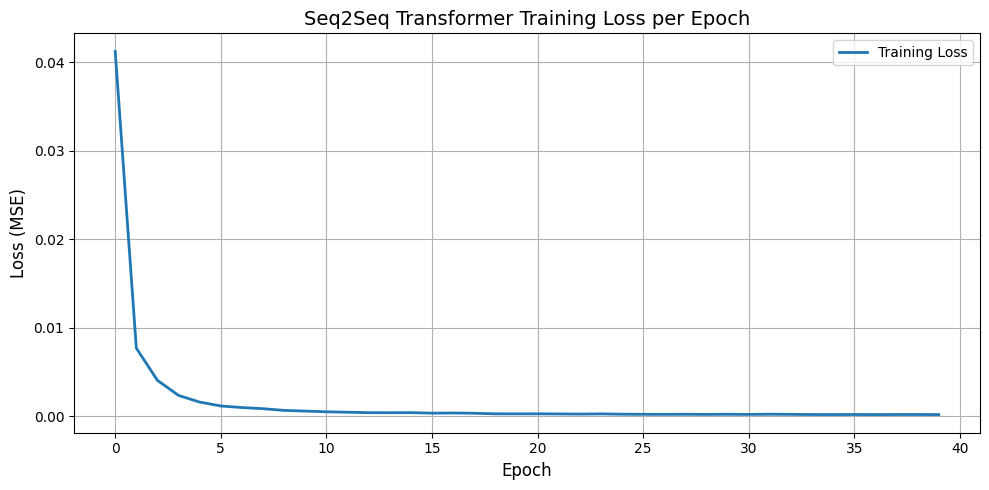

In [65]:
plt.figure(figsize=(10,5))
plt.plot(loss_history, label='Training Loss', linewidth=2)

plt.title("Seq2Seq Transformer Training Loss per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()